In [20]:
# Step 1: Import dependencies
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, windows
import pytz
# print(pytz.all_timezones)

,abs_timestamp,timestamp,reference,x,y,z,datetime
0,1.742522e+09,-5.000000,0.000000,0.000000,0.000000,0.000000,2025-03-20 22:54:12.616471767-03:00
1,1.742522e+09,-4.999000,0.000000,0.000000,0.000000,0.000000,2025-03-20 22:54:12.617471933-03:00
2,1.742522e+09,-4.998000,0.000000,0.000000,0.000000,0.000000,2025-03-20 22:54:12.618472099-03:00
3,1.742522e+09,-4.996999,0.000000,0.000000,0.000000,0.000000,2025-03-20 22:54:12.619472265-03:00
4,1.742522e+09,-4.995999,0.000000,0.000000,0.000000,0.000000,2025-03-20 22:54:12.620472670-03:00
...,...,...,...,...,...,...,...
59995,1.742524e+09,26.107999,-0.127345,-0.023011,0.002884,0.001595,2025-03-20 23:20:10.573942900-03:00
59996,1.742524e+09,26.108999,-0.123751,-0.007732,0.003104,0.001492,2025-03-20 23:20:10.574943304-03:00
59997,1.742524e+09,26.110000,-0.120005,-0.043360,0.003214,0.001980,2025-03-20 23:20:10.575943470-03:00
59998,1.742524e+09,26.111000,-0.116027,-0.062698,0.003257,0.001364,2025-03-20 23:20:10.576943636-03:00


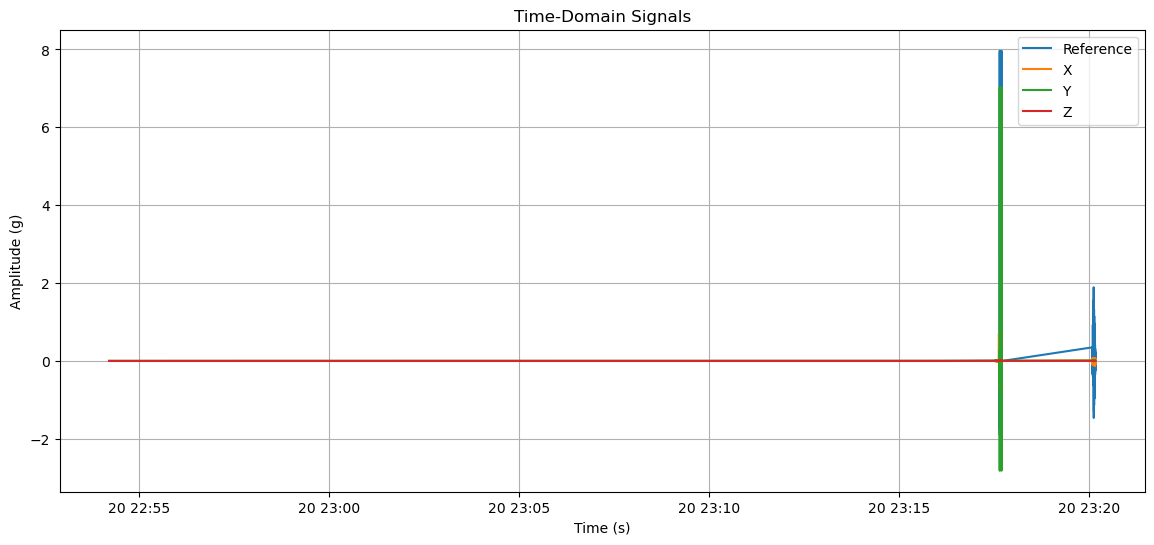

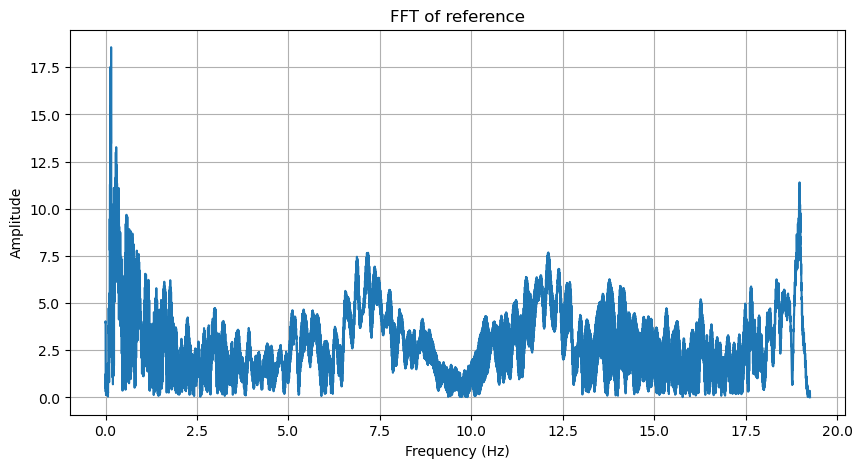

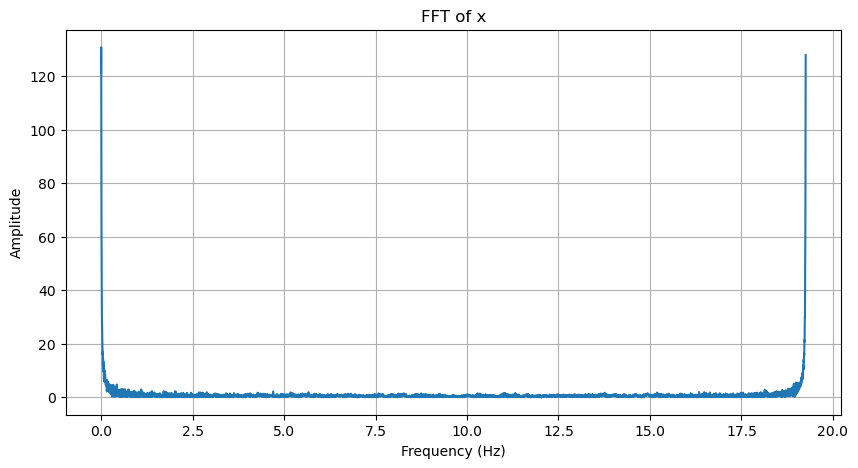

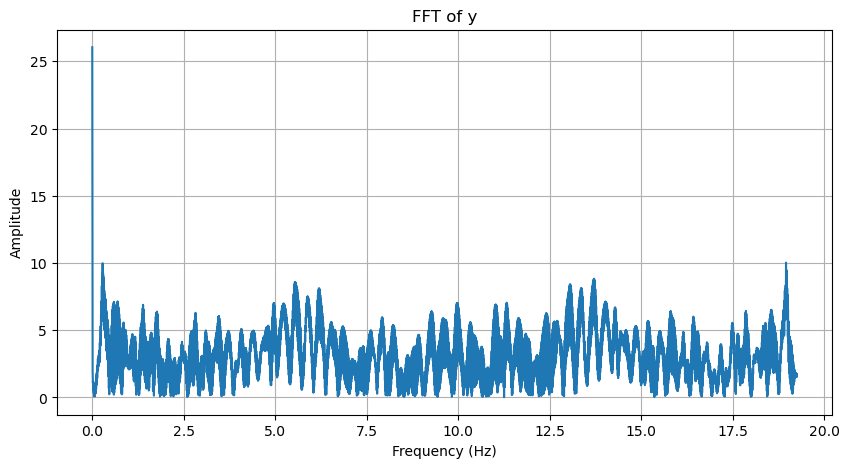

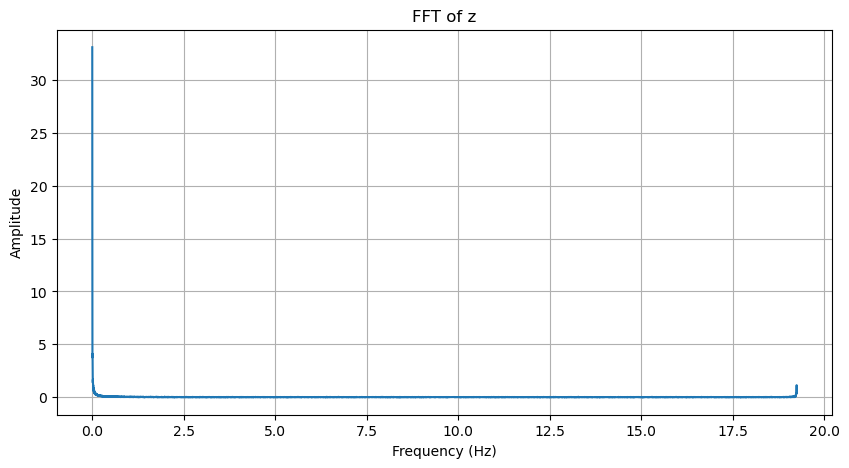

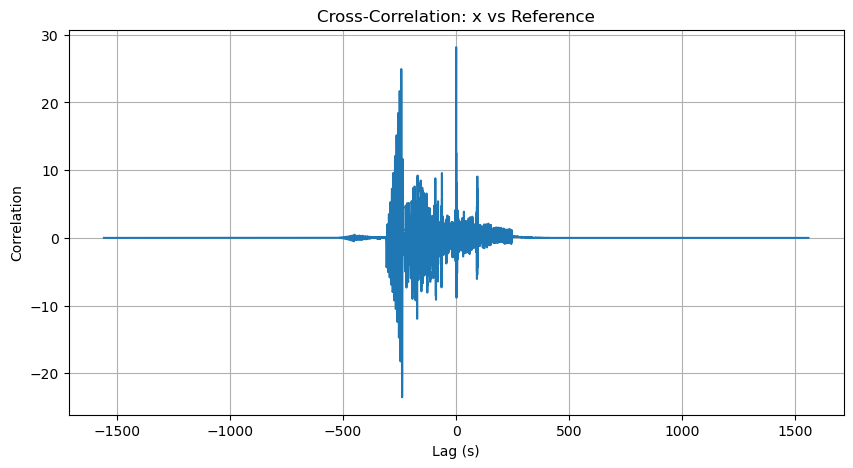

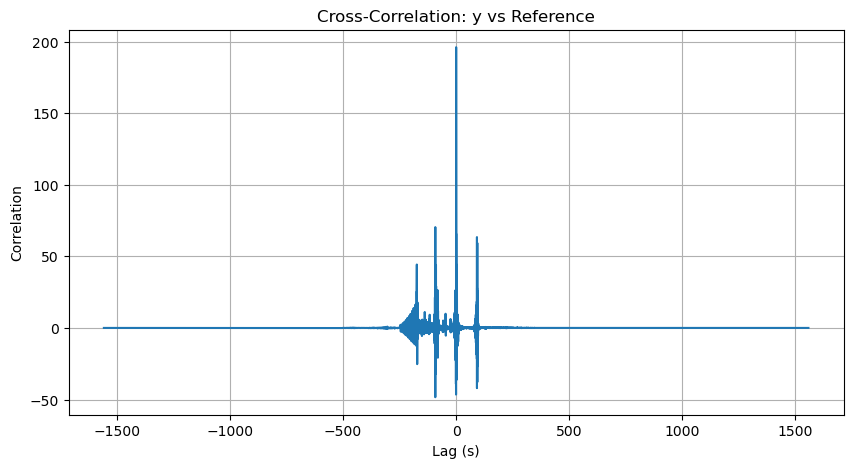

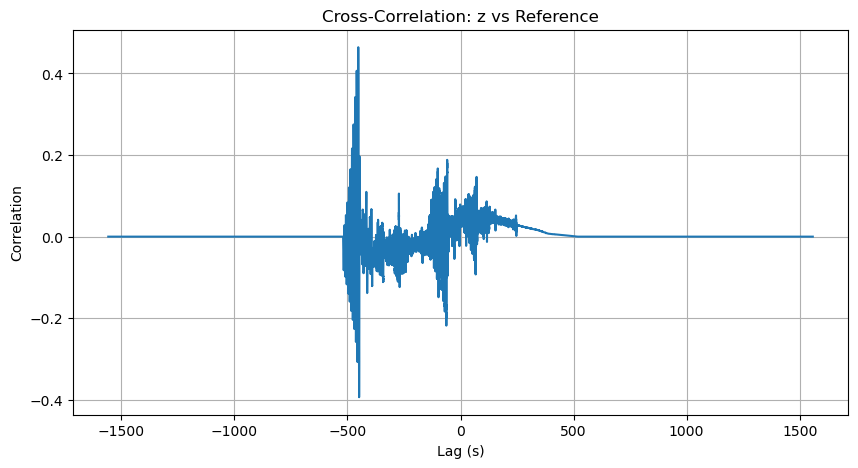

In [21]:
# Step 2: Read the database
db_name = "vibration_data00.sqlite"

conn = sqlite3.connect(db_name)
query = "SELECT * FROM vibration_samples ORDER BY abs_timestamp"
df = pd.read_sql(query, conn)
conn.close()

# Step 3: Display the database
df['datetime'] = pd.to_datetime(df['abs_timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('America/Sao_Paulo')
display(df)

# Step 4: Plot time-domain signals
plt.figure(figsize=(14, 6))
plt.plot(df['datetime'], df['reference'], label='Reference')
plt.plot(df['datetime'], df['x'], label='X')
plt.plot(df['datetime'], df['y'], label='Y')
plt.plot(df['datetime'], df['z'], label='Z')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (g)")
plt.title("Time-Domain Signals")
plt.legend()
plt.grid(True)
plt.show()

# Step 5: FFT analysis
sample_rate_estimate = 1 / np.mean(np.diff(df['abs_timestamp']))

def plot_fft(signal, sample_rate, title):
    N = len(signal)
    windowed = signal * windows.hann(N)
    freqs = np.fft.rfftfreq(N, d=1/sample_rate)
    fft_vals = np.abs(np.fft.rfft(windowed))

    plt.figure(figsize=(10, 5))
    plt.plot(freqs, fft_vals)
    plt.title(f"FFT of {title}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

for ch in ['reference', 'x', 'y', 'z']:
    plot_fft(df[ch].values, sample_rate_estimate, ch)

# Step 6: Cross-correlation between Reference and other channels
def plot_cross_correlation(ref, signal, sample_rate, label):
    corr = correlate(signal, ref, mode='full')
    lags = np.arange(-len(ref) + 1, len(ref)) / sample_rate
    plt.figure(figsize=(10, 5))
    plt.plot(lags, corr)
    plt.title(f"Cross-Correlation: {label} vs Reference")
    plt.xlabel("Lag (s)")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.show()

ref = df['reference'].values
for axis in ['x', 'y', 'z']:
    plot_cross_correlation(ref, df[axis].values, sample_rate_estimate, axis)
